# Analysis

## Importing libraries

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)

import os 
import requests
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

from itertools import chain
from collections import Counter
import shutil
import zipfile
from urllib.parse import urlparse


## Loading data

Need to implement generalized function or folder to download and extract zip to folders 

In [ ]:
def download_and_extract(url, extract_to='data', folder_to_delete=None):
    file_name = os.path.basename(urlparse(url).path)
    download_path = os.path.join(extract_to, file_name)
    os.makedirs(extract_to, exist_ok=True)

    print(f"Downloading file from {url}...")
    response = requests.get(url)
    if response.status_code == 200:
        with open(download_path, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded successfully to {download_path}")
    else:
        raise Exception(f"Failed to download file. Status code: {response.status_code}")
    if zipfile.is_zipfile(download_path):
        print(f"Extracting {file_name}...")
        with zipfile.ZipFile(download_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Files extracted to {extract_to}")

    else:
        print(f"{file_name} is not a zip file. No extraction needed.")
        return
    if folder_to_delete:
        folder_to_delete_path = os.path.join(extract_to, folder_to_delete)
        if os.path.isdir(folder_to_delete_path):
            shutil.rmtree(folder_to_delete_path)
            print(f"Deleted folder: {folder_to_delete_path}")
        else:
            print(f"Folder '{folder_to_delete}' not found in {extract_to}.")


url_movie_dataset_public = "https://files.grouplens.org/datasets/tag-genome-2021/genome_2021.zip" 
download_and_extract(url_movie_dataset_public, extract_to="data", folder_to_delete="__MACOSX")

File downloaded successfully to data\genome_2021.zip
Extracting genome_2021.zip...
Files extracted to data
Deleted folder: data\__MACOSX


In [197]:
CMU_df = pd.read_pickle('./data/CMU_cleaned.pkl')
TMDB_df = pd.read_csv('./data/TMDBMovies/TMDB_movie_dataset_v11.csv', sep=',', header=0)
combined_df = pd.read_pickle('./data/combined_dataset.pkl')

## World-wide movie distribution

In [198]:
TMDB_countries_df = TMDB_df.dropna(subset=['production_countries'])

countries = TMDB_countries_df["production_countries"].apply(lambda x: x.split(', ')).tolist()
counts = Counter(list(chain(*countries)))
counts_df =  pd.DataFrame({"country": list(counts.keys()), "movie_count": list(counts.values())}).sort_values(by='movie_count', ascending=False).reset_index(drop=True)
counts_df['log_transformed_count'] = np.log1p(counts_df['movie_count'])  # log1p(x) = log(1 + x) to handle zeroes
counts_df.head(10)

country  movie_count  log_transformed_count
0  United States of America       192245              12.166531
1                    France        44663              10.706923
2                   Germany        41821              10.641178
3                     Japan        41660              10.637321
4            United Kingdom        41023              10.621913
5                    Canada        24286              10.097697
6                     India        21243               9.963830
7                     Italy        18841               9.843844
8                    Brazil        17011               9.741674
9                     Spain        15172               9.627273

In [199]:
fig = px.choropleth(
    counts_df,
    locations='country',
    locationmode='country names',
    color='log_transformed_count',
    color_continuous_scale='peach',
    title='Frequency of Movies Published by Country',
    labels={'log_transformed_count': 'Log-transform amout'},
    template='plotly_dark'
)

fig.show()


## All-time movie distribution

### With the CMU-TMDB combined dataset

<Axes: xlabel='release_year'>

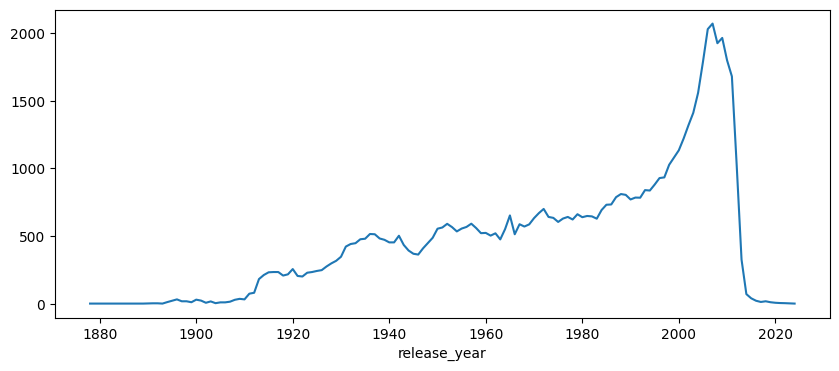

In [200]:
combined_df['release_year'] = pd.to_datetime(combined_df['release_date_final'], format='mixed').dt.year
movies_by_year = combined_df.groupby('release_year')['movie_name'].count()
movies_by_year.plot(kind='line', figsize=(10, 4))

We see a interesting trend with a rapid increase in movie release starting roughly between 1990 and 2000.

### All-time evolution by genre

In [202]:
combined_df['genres_all'] = combined_df['genres'] + combined_df['movie_genres']
combined_df['genres_all'] =combined_df['genres_all'].apply(lambda x: list(set(x)) if x is not np.nan else [])
combined_df.drop(columns=['genres', 'movie_genres'], inplace=True)

In [245]:
all_unique_genres = list(set(chain(*combined_df['genres_all'])))
all_unique_genres.sort()
all_unique_genres

['Absurdism',
 'Acid western',
 'Action',
 'Action Comedy',
 'Action Thrillers',
 'Action/Adventure',
 'Addiction Drama',
 'Adult',
 'Adventure',
 'Adventure Comedy',
 'Airplanes and airports',
 'Albino bias',
 'Alien Film',
 'Alien invasion',
 'Americana',
 'Animal Picture',
 'Animals',
 'Animated Musical',
 'Animated cartoon',
 'Animation',
 'Anime',
 'Anthology',
 'Anthropology',
 'Anti-war',
 'Anti-war film',
 'Apocalyptic and post-apocalyptic fiction',
 'Archaeology',
 'Archives and records',
 'Art film',
 'Auto racing',
 'Avant-garde',
 'B-Western',
 'B-movie',
 'Backstage Musical',
 'Baseball',
 'Beach Film',
 'Beach Party film',
 'Bengali Cinema',
 'Biker Film',
 'Biographical film',
 'Biography',
 'Biopic [feature]',
 'Black comedy',
 'Black-and-white',
 'Blaxploitation',
 'Bloopers & Candid Camera',
 'Bollywood',
 'Boxing',
 'Breakdance',
 'British Empire Film',
 'British New Wave',
 'Bruceploitation',
 'Buddy Picture',
 'Buddy cop',
 'Buddy film',
 'Business',
 'Camp',
 'Cap

In [255]:
combined_by_genre_year = combined_df.groupby('release_year')
aggregate = combined_by_genre_year.agg({'genres_all': lambda x: list(chain(*x))})

genre_selection = [
  	'Drama',
    'Science Fiction', 
    'Horror', 
    'Thriller', 
    'Crime', 
    'Adventure', 
    'Action', 
    'Musical', 
    'Comedy', 
    'Romance',
    'Fantasy',
		'Animation',
		'Western',
		'Apocalyptic and post-apocalyptic fiction',
		'Family',
		'Mystery',
    'History',
    'Documentary',
    'Black-and-white',
    'War',
    ]
for genre in genre_selection:
		aggregate[genre] = aggregate['genres_all'].apply(lambda x: x.count(genre))
aggregate.head(3)

genres_all  Drama  \
release_year                                                             
1878.0                   [Documentary, Silent film, Short Film]      0   
1888.0        [Silent film, Black-and-white, Documentary, Sh...      0   
1889.0        [Silent film, Black-and-white, Documentary, Sh...      0   

              Science Fiction  Horror  Thriller  Crime  Adventure  Action  \
release_year                                                                
1878.0                      0       0         0      0          0       0   
1888.0                      0       0         0      0          0       0   
1889.0                      0       0         0      0          0       0   

              Musical  Comedy  Romance  Fantasy  Animation  Western  \
release_year                                                          
1878.0              0       0        0        0          0        0   
1888.0              0       0        0        0          0        0   
1889.0              0       0        0        0          0        0   

              Apocalyptic and post-apocalyptic fiction  Family  Mystery  \
release_year                                                              
1878.0                                               0       0        0   
1888.0                                               0       0        0   
1889.0                                               0       0        0   

              History  Documentary  Black-and-white  War  
release_year                                              
1878.0              0            1                0    0  
1888.0              0            1                1    0  
1889.0              0            1                1    0

<Axes: xlabel='release_year'>

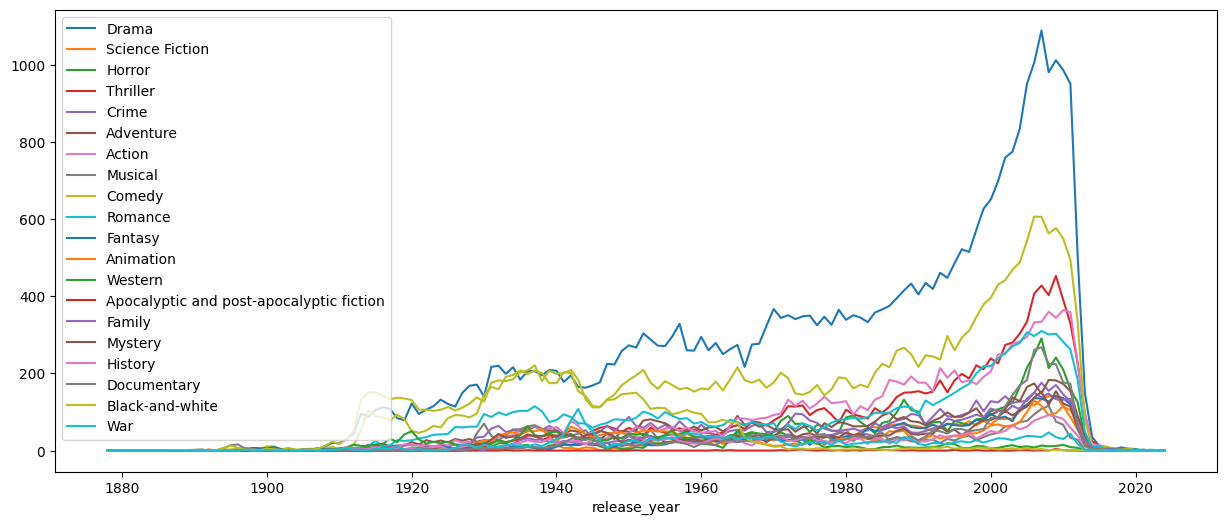

In [256]:
aggregate.plot(y=genre_selection, figsize=(15, 6))

Here we see that the evolution across genres mostly follows the trend we saw earlier when plotting the number of movies released each year. This make sense, but there are some exceptions...

<Axes: xlabel='release_year'>

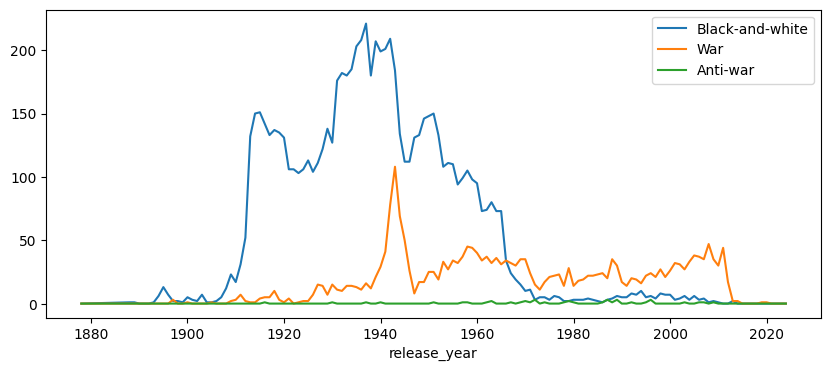

In [ ]:
aggregate.plot(y=['Black-and-white', 'War'], figsize=(10, 4))

In fact, when plotting 'War' movies, we see thatthere is a big peak around the 1939-1945 period corresponding to WWII but there is no obvious increase in 'War' movies thereafter.
When plotting 'Black-and-white' movies, on the other hand, we see that, as technology advanced and color movies became more and more popular, the 'Black-and-white' genre rapidly declined after WWII.

## Exploring genre success over the years

<Axes: xlabel='release_year'>

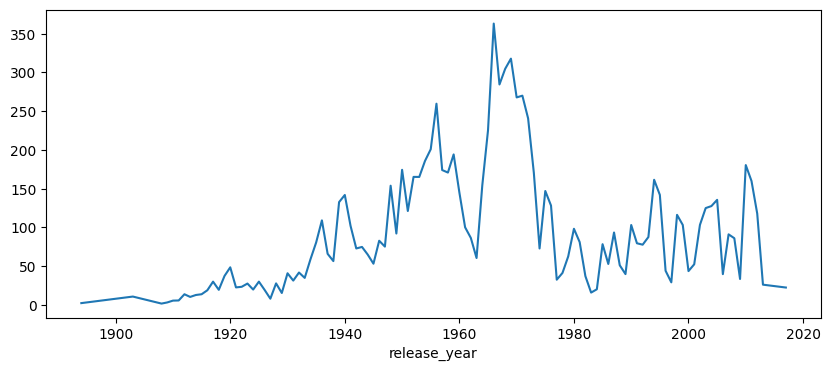

In [258]:
filtered_df = combined_df[combined_df['genres_all'].apply(lambda genres: 'Western' in genres)]
filtered_df.groupby('release_year')['popularity'].sum().plot(kind='line', figsize=(10, 4))

## Proof of concepts for the methods

In this section, we want to show simple examples of the methods we are going to use in our project to prove that they work. Of course, the cases we are going to be analyzing in the final project are going to be more complex then these examples, but this serves only as a proof of concept. 

### Part 1 - Change point analysis

#### Model used for sentiment analysis example 
Labels: 0 -> Negative; 1 -> Neutral; 2 -> Positive

In [1]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# Loading a Pre-Trained Model from HuggingFace Hub
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

# Creating a Function to Run the Application
def run_classification(text):
    result = classifier(text)
    return result

# Running the Application
input_text = "I love using HuggingFace models for NLP tasks!"
pos_result = run_classification(input_text)
print(f"Input: {input_text}")
print(f"Classification: {pos_result}")

c:\Users\basti\anaconda3\envs\ada\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Input: I love using HuggingFace models for NLP tasks!
Classification: [{'label': 'LABEL_2', 'score': 0.9852126836776733}]


Thus the score is quite positive, as the label is 2 ! Yay, that's exactly what we expected 

In [ ]:
input_text = "I hate handing in my assignments on the last day!"
neg_result = run_classification(input_text)
print(f"Input: {input_text}")
print(f"Classification: {neg_result}")

Input: I hate handing in my assignments on the last day!
Classification: [{'label': 'LABEL_0', 'score': 0.937169075012207}]


Here, as the lab is 0 it's a negative assessment...

In [ ]:
input_text = "The movie had a mix of strengths and weaknesses. Some aspects, like the cinematography, were well done, while others, such as the pacing, could have been improved"
neut_result = run_classification(input_text)
print(f"Input: {input_text}")
print(f"Classification: {neut_result}")

Input: The movie had a mix of strengths and weaknesses. Some aspects, like the cinematography, were well done, while others, such as the pacing, could have been improved
Classification: [{'label': 'LABEL_1', 'score': 0.49330204725265503}]


Once again on the mark !
We will thus implement this for our reviews.

### Part 2 - 

For part 2, we do not have any new method to implement, simply more specific plots.

### Part 3 - Predictive models

The first model we test in the polynomial regression

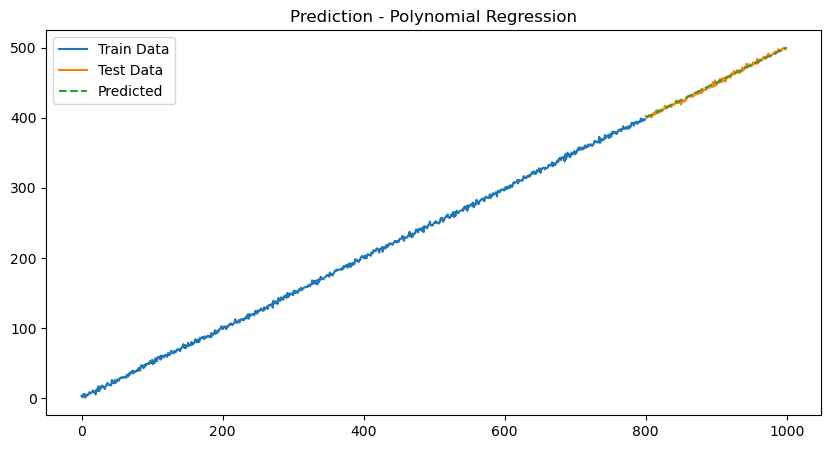

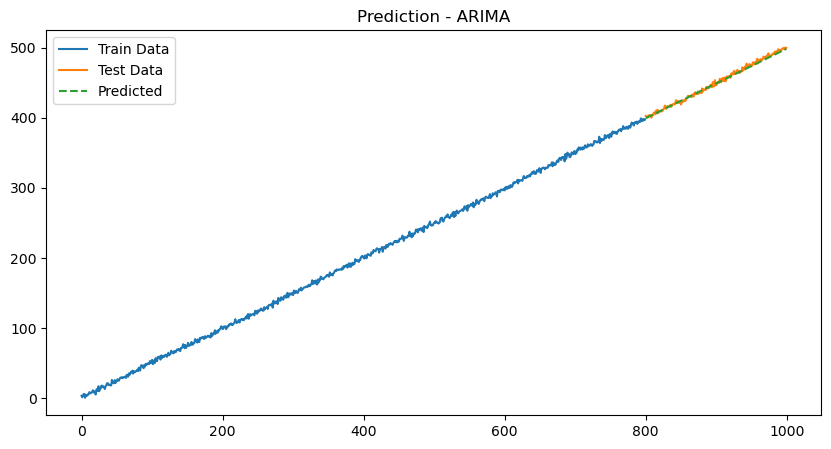

In [ ]:
from src.models.PolynomialRegression import polynomial_regression
from src.models.ARIMA import arima
from src.utils.print_prediction import plot_results

np.random.seed(0)
n = 1000
time_series = pd.Series(0.5 * np.arange(n) + np.sin(np.linspace(0, 20, n)) + np.random.normal(scale=2, size=n))
train, test = time_series[:800], time_series[800:]

poly_predictions = polynomial_regression(train, degree=3, n_forecast=len(test))
plot_results(train, test, poly_predictions, "Prediction - Polynomial Regression")

order = (50, 1, 50)  # (p,d,q)
# p is the number of previous points used to make the prediction
# d is the differentiating order to eliminate trends
# q is the moving average window

arima_predictions = arima(train, order=(2, 1, 2), n_forecast=len(test))
plot_results(train, test, arima_predictions, "Prediction - ARIMA")

One important thing to note is that the ARIMA model seem to be performing worse when the number of samples in the timeseries is smaller (See below). This could be an issue when using the year of release for movies. This problem might be resolved with a better initial choices of parameters for the model. However, if the issue persists, we might need to consider using the year and month for movie release to get more values in our timeseries.

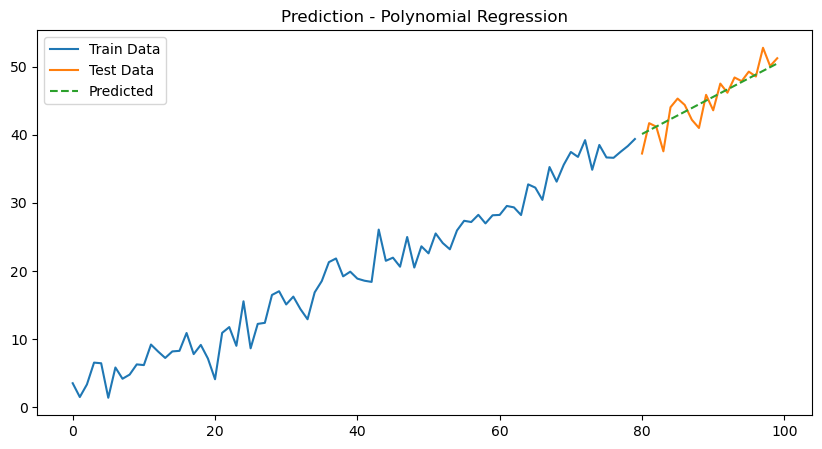

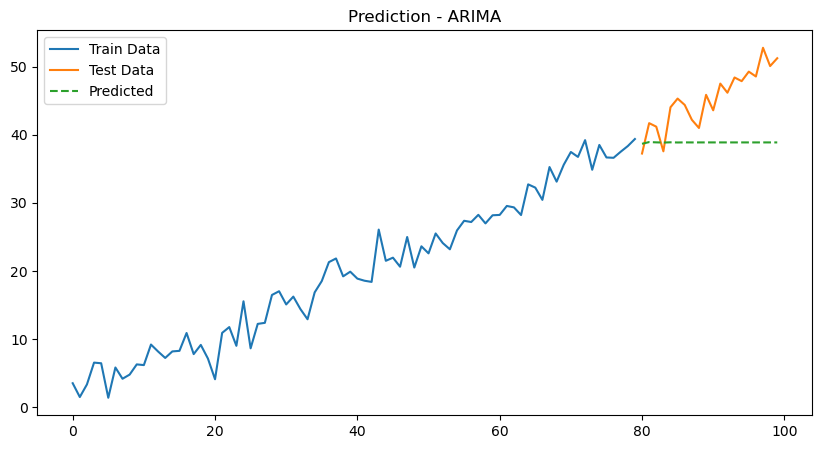

In [ ]:
np.random.seed(0)
n = 100
time_series = pd.Series(0.5 * np.arange(n) + np.sin(np.linspace(0, 20, n)) + np.random.normal(scale=2, size=n))
train, test = time_series[:80], time_series[80:]

poly_predictions = polynomial_regression(train, degree=3, n_forecast=len(test))
plot_results(train, test, poly_predictions, "Prediction - Polynomial Regression")

order = (20, 1, 20) 

arima_predictions = arima(train, order=(2, 1, 2), n_forecast=len(test))
plot_results(train, test, arima_predictions, "Prediction - ARIMA")